## Imports i definició de les variables d'arxius
---

In [1]:

import re #Regexs
import os #Acces a fitxers

import nltk #Tokenització
nltk.download('punkt') #Tokenització

import numpy as np #Matriu de confusió
import seaborn as sns #Matriu de confusió
import matplotlib.pyplot as plt #Matriu de confusió
import sklearn #Matriu de confusió

train_files_list = [f for f in os.listdir('corpora') if re.search(r'_trn\.txt$', f)]
test_files_list = [f for f in os.listdir('corpora') if re.search(r'_tst\.txt$', f)]

print(train_files_list)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['deu_trn.txt', 'eng_trn.txt', 'fra_trn.txt', 'ita_trn.txt', 'nld_trn.txt', 'spa_trn.txt']


## Preprocessing
---

· Eliminar digits del text 
· Convertir tot el text a minuscula
· Eliminar caracters especials
· Substitueix els espais en blanc continus per un de sol
· Concatena totes les frases amb un espai doble al mig


In [2]:

def preprocessing(text):
    
    text = re.sub(r'[^\w\s]', '', text) # Elimina signes de puntuació
    text = re.sub(r'\d+', '', text) # Elimina números
    text = text.lower() # Converteix a minúscules
    text = re.sub(r'[\s\n]+', ' ', text) # Elimina espais en blanc sobrants excepte \n
    text = re.sub(r' +', ' ', text) # Elimina espais en blanc llargs
    text = re.sub(r'\n', '  ', text) # Substitueix \n per dos espais en blanc
    
    return text


# Creació dels trigrames amb la seva freqüència
---

Creació de les funcions bàsiques per a la generació i assignació dels trigrames de caracters i bigrames de paraules

In [3]:
# Estructura de dades de les variables dels trigrames
# {key: id_idioma value: 
#   {key: trigrama, value: freqüència}}

# Reb un text i retorna un diccionari amb els trigrames i les seves freqüències

def character_trigrams_finder(text, flag='trn'):
    finder = nltk.TrigramCollocationFinder.from_words(text)
    if flag == 'trn':
        finder.apply_freq_filter(5)
    trigrams = finder.ngram_fd.items()
    trigrams_dict = {trigram: count for trigram, count in trigrams}
    
    return trigrams_dict

def word_trigrams_finder(text):
    finder = nltk.BigramCollocationFinder.from_words(nltk.word_tokenize(text))
    trigrams = finder.ngram_fd.items()
    trigrams_dict = {trigram: count for trigram, count in trigrams}

    return trigrams_dict

---

In [4]:

# Reb una llista amb els noms dels fitxers, guarda els textos dels arxius indexats, 
# Els preprocessa i en extreu els trigrames retornant un diccionari

def trigram_assigner_ch(train_files_list):
    
    enclosed_trigrams_ch = {}

    for file in train_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID de l'idioma
            print(language_id)
            text = f.read()
            text = preprocessing(text)
            enclosed_trigrams_ch[language_id] = character_trigrams_finder(text)

    return enclosed_trigrams_ch

def trigram_assigner_wds(train_files_list):
    enclosed_trigrams_wds = {}
    for file in train_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID de l'idioma
            print(language_id)
            text = f.read()
            text = preprocessing(text)
            enclosed_trigrams_wds[language_id] = word_trigrams_finder(text)
            
    return enclosed_trigrams_wds


In [5]:
trigrams_ch = trigram_assigner_ch(train_files_list)
print()
trigrams_wds = trigram_assigner_wds(train_files_list)

deu
eng
fra
ita
nld
spa

deu
eng
fra
ita
nld
spa


## Separa el test per oracions
---

In [6]:

def test_files_separator(test_files_list):
    test_files = {}
    for file in test_files_list:
        with open('corpora/' + file, 'r', encoding='utf-8') as f:
            language_id = file.split('_')[0] # ID de l'idioma
            print(language_id)
            text = f.read()
            test_files[language_id] = nltk.sent_tokenize(text)
            for i in range(len(test_files[language_id])):
                test_files[language_id][i] = preprocessing(test_files[language_id][i])
    return test_files

In [7]:
test_files = test_files_separator(test_files_list)

deu
eng
fra
ita
nld
spa


## Elimina les oracions amb menys de 3 caracters
---

In [9]:
# Diccionari de totes les frases de cada idioma dels fitxers de test
# Key: Id idioma, Value: Llista de frases
# Elimina les frases amb menys de 3 caràcters
for idioma in trigrams_ch:
    test_files[idioma] =  [elemento for elemento in test_files[idioma] if len(elemento) >= 3]
    
print()

for idioma in trigrams_wds:
    test_files[idioma] =  [elemento for elemento in test_files[idioma] if len(elemento) >= 3]

## Funcio de suavitzat
---


Sumatori del logaritme de (les aparicions del trigrama en el train + alpha / trigrames que apareixen en el train + alpha * vocabulari(beta))

In [10]:

# Reb com a parametres una oracio i un flag que pot ser 'chars' o 'words' i un alpha que per defecte es 0.5
def suavitzat(oracio, flag = 'chars', prints = False, alpha = 0.5):
    #chars es un dict, trigrams_ch es un dict
    if flag == 'chars':
        chars = character_trigrams_finder(oracio, 'test')
    elif flag == 'words':
        chars = word_trigrams_finder(oracio)
    probabilities = {}
    for idioma in trigrams_ch: #iterem per idioma
        prob = 0
        for trigram in chars.keys(): #Agafa un trigrama concret de la frase
            if flag == 'chars':      #Busca el nombre d'aparicions d'aquest trigrama concret al diccionari
                aparicions = trigrams_ch[idioma].get(trigram, 0)
                beta = (len(trigrams_ch[idioma]))
            if flag == 'words':
                aparicions = trigrams_wds[idioma].get(trigram, 0)
                beta = (len(trigrams_ch[idioma])*3)
            prob_trigrama = ((aparicions + alpha) / ((len(trigrams_ch[idioma])) + alpha * beta)) # la nostra beta (trigrames totals del idioma) es el nombre de trigrames totals del train
            prob += np.log(prob_trigrama)
        probabilities[idioma] = prob
    sorted_prob = sorted(probabilities.items(), key=lambda x:x[1], reverse=True)
    sort_prob = dict(sorted_prob)
    if prints == True:
        print(oracio, '\n')
        print (' L\'idioma de la oració és:', list(sort_prob.keys())[0])
        print ('\n', sort_prob)
    return list(sort_prob.keys())[0]



In [11]:
# Debug d'una frase concreta qualsevol
suavitzat(test_files['eng'][6], 'words', True, 0.5)

 an unconfirmed report emerges that the hostagetaker at the supermarket is the person police were looking for in connection with the killing of a policewoman in a southern paris suburb on thursday 

 L'idioma de la oració és: eng

 {'eng': -239.5976846134537, 'ita': -312.53414464869826, 'spa': -318.146347171231, 'nld': -318.7332226282674, 'fra': -325.0410421842024, 'deu': -327.65555844136463}


'eng'

## Matrius de Confusió per paraules i caracters
---

Executem el 'smoothing' per obtindre les prediccions, les guardem en les llistes, i mitjançant les llibreries importades, es construeixen les dues matrius de confusió amb el count dels cops en que una predicció ha sigut acertada:
- Matriu de confusió per caracters
- Matriu de confusió per paraules

In [12]:
# Crida a la funció de 'smoothing' per a cada frase dels fitxers de test, i guarda les prediccions i els valors objectius.

prediccio_words = []
valor_obj_words = []

prediccio_chars = []
valor_obj_chars = []

for idioma in test_files:
    for oracio in test_files[idioma]:
        valor_obj_chars.append(idioma)
        valor_obj_words.append(idioma)
        prediccio_chars.append(suavitzat(oracio, 'chars', False, 0.5))
        prediccio_words.append(suavitzat(oracio, 'words', False, 0.5))


Matriu de Confusió de Caracters:
[[10352    71    13    28    16    11]
 [    3 10046     0    14     1     2]
 [    1    24 10054    23     3     7]
 [    0     9     2 10167     3     3]
 [   17   102     8    21 10152    12]
 [    1     9     4    25     5  9898]]


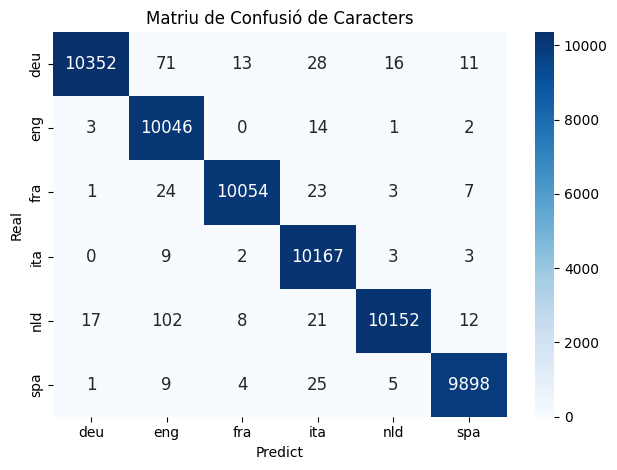

Matriu de Confusió de Paraules:
[[ 9791    22     2   668     8     0]
 [   17  9951     1    96     0     1]
 [    2     0 10110     0     0     0]
 [    8     0     0 10175     1     0]
 [   27    13     3   202 10067     0]
 [   26     0     0     1     0  9915]]


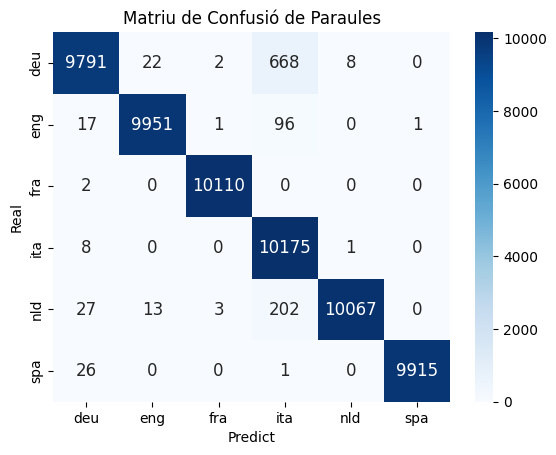

In [21]:
matriu_confusio_chars = sklearn.metrics.confusion_matrix(valor_obj_chars, prediccio_chars)
matriu_confusio_words = sklearn.metrics.confusion_matrix(valor_obj_words, prediccio_words)

labels = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']

print("Matriu de Confusió de Caracters:")
print(matriu_confusio_chars)

### Matriu de confusió de caracters
sns.heatmap(matriu_confusio_chars, annot=True, annot_kws={"size": 12}, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriu de Confusió de Caracters')
plt.tight_layout()
plt.show()


print("Matriu de Confusió de Paraules:")
print(matriu_confusio_words)


### Matriu de confusió de paraules
sns.heatmap(matriu_confusio_words, annot=True, annot_kws={"size": 12}, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriu de Confusió de Paraules')
plt.tight_layout
plt.show()


## Matrius de confusió amb el 'accuracy'
---

Calculem el 'accuracy general de les prediccions, tant per caracters com per paraules, i construim les seves respectives matrius de confusió mostrant aquest cop el percentatge d'èxit:
- Matriu de confusió amb 'accuracy' dels caracters
- Matriu de confusió amb 'accuracy' de les paraules

Accuracy for chars:  0.9928322450783053
Accuracy for words:  0.9820315184839707

Matriu de confusió de caracters amb accuracy:


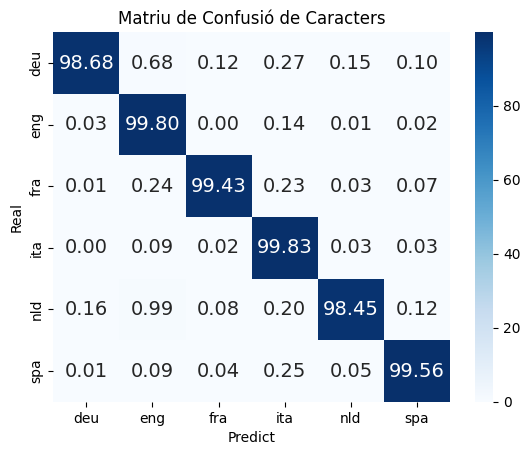


Matriu de confusió de paraules amb accuracy:


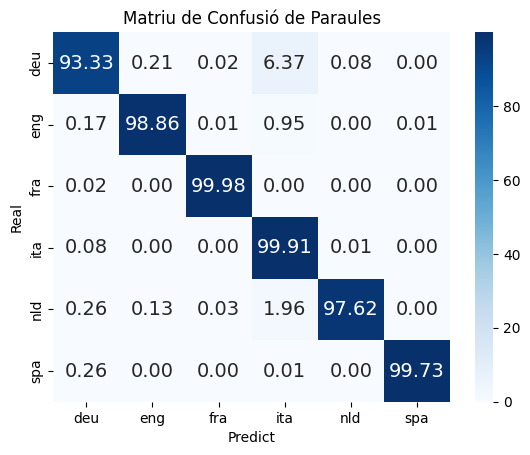

In [20]:

#calculem la accuracy
accuracy_chars = sklearn.metrics.accuracy_score(valor_obj_chars, prediccio_chars)
accuracy_words = sklearn.metrics.accuracy_score(valor_obj_words, prediccio_words)
print("Accuracy for chars: ", accuracy_chars)
print("Accuracy for words: ", accuracy_words)

#fem la matriu de confusio amb la accuracy
matriu_confusio_chars = np.round(matriu_confusio_chars / matriu_confusio_chars.sum(axis=1)[:, np.newaxis] * 100, decimals=29)
matriu_confusio_words = np.round(matriu_confusio_words / matriu_confusio_words.sum(axis=1)[:, np.newaxis] * 100, decimals=29)

### Matriu de confusió de caracters amb accuracy
print("\nMatriu de confusió de caracters amb accuracy:")
sns.heatmap(matriu_confusio_chars, annot=True, annot_kws={"size": 14}, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriu de Confusió de Caracters')
plt.show()


### Matriu de confusió de paraules amb accuracy
print("\nMatriu de confusió de paraules amb accuracy:")
sns.heatmap(matriu_confusio_words, annot=True, annot_kws={"size": 14}, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predict')
plt.ylabel('Real')
plt.title('Matriu de Confusió de Paraules')
plt.show()
